In [1]:
 import numpy as np
import pandas as pd

# Load the CSV file, ignoring dtype warnings by setting low_memory=False
df = pd.read_csv('position_velocity_data.csv', low_memory=False)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep = df['real_timestep_s'].values[0]

# Convert them to numpy arrays
# positions = [df[col].astype(float).values for col in position_cols]
# velocities = [df[col].astype(float).values for col in velocity_cols]
positions = np.array([df[col].astype(float).values for col in position_cols])
velocities = np.array([df[col].astype(float).values for col in velocity_cols])

# Optionally, convert to numpy arrays with shape (num_traces, num_points)
positions = np.array(positions)
velocities = np.array(velocities)

# Print the shapes to verify
print(f"Positions shape: {positions.shape}")
print(f"Velocities shape: {velocities.shape}")


Positions shape: (4, 45071789)
Velocities shape: (4, 45071789)


In [2]:
bin_num = 1000
fs = 1/(timestep*bin_num)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces = []
for trace in positions:
    series = bin_data(trace, bin_num)
    traces.append(series)

V_traces = []
for trace in velocities:
    series = bin_data(trace, bin_num)
    V_traces.append(series)

zero idx: [  405   422   440   840  1483  1554  1905  1966  2182  2207  2499  2686
  3011  3091  3216  3221  3344  3857  4370  4565  4800  4860  5419  6289
  6500  6537  7000  7030  7214  7458  7602  7879  8144  8645  8967  9015
  9041 10254 11296 12077 12175 12342 12481 12678 13230 13429 13442 13446
 14203 14218 14262 14768 14943 15085 15165 15253 15531 15548 15684 15688
 16057 16097 16497 16702 16799 16854 16903 17111 17449 17572 17796 18007
 18173 18260 18495 18865 18869 19280 19671 19919 21137 21163 21201 21353
 22163 22573 22579 22828 23011 23355 23392 24096 24180 24195 24408 24422
 25125 25424 26129 26268 26355 26388 26456 26719 26771 27068 27125 27775
 27954 28619 28673 28804 28984 29192 29387 29697 30348 30524 30828 31094
 31132 31377 31400 31590 31765 31989 32466 32790 32971 32980 33046 33084
 33175 33306 33480 33657 33658 33692 33829 33834 34004 34191 34632 35563
 36086 36908 36975 37217 37240 37655 37828 38523 38793 38817 38907 38971
 39179 39444 39448 39953 40045 40340 4064

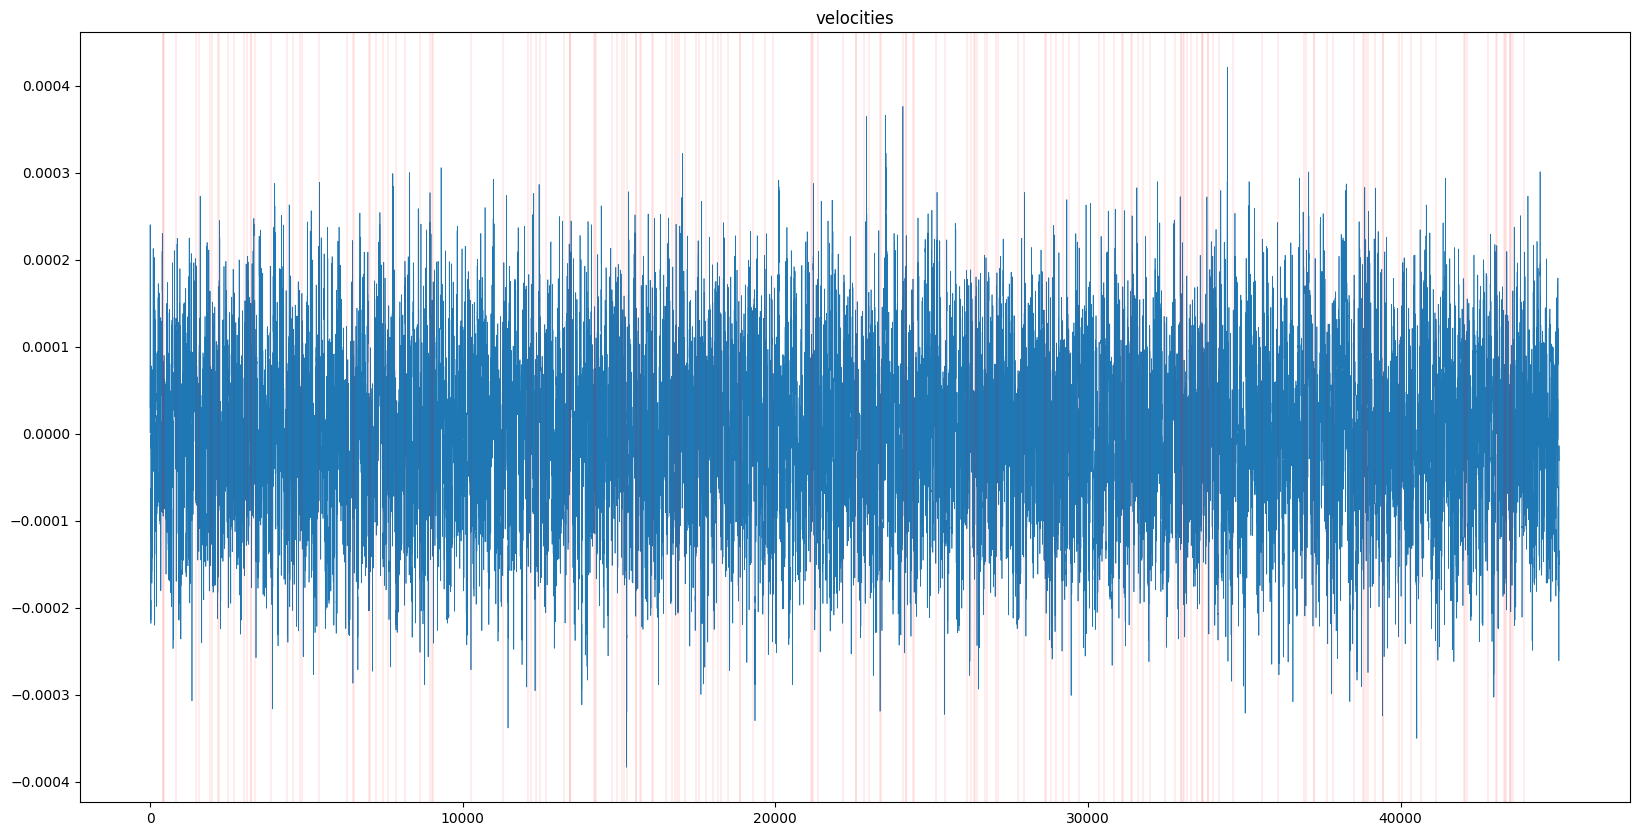

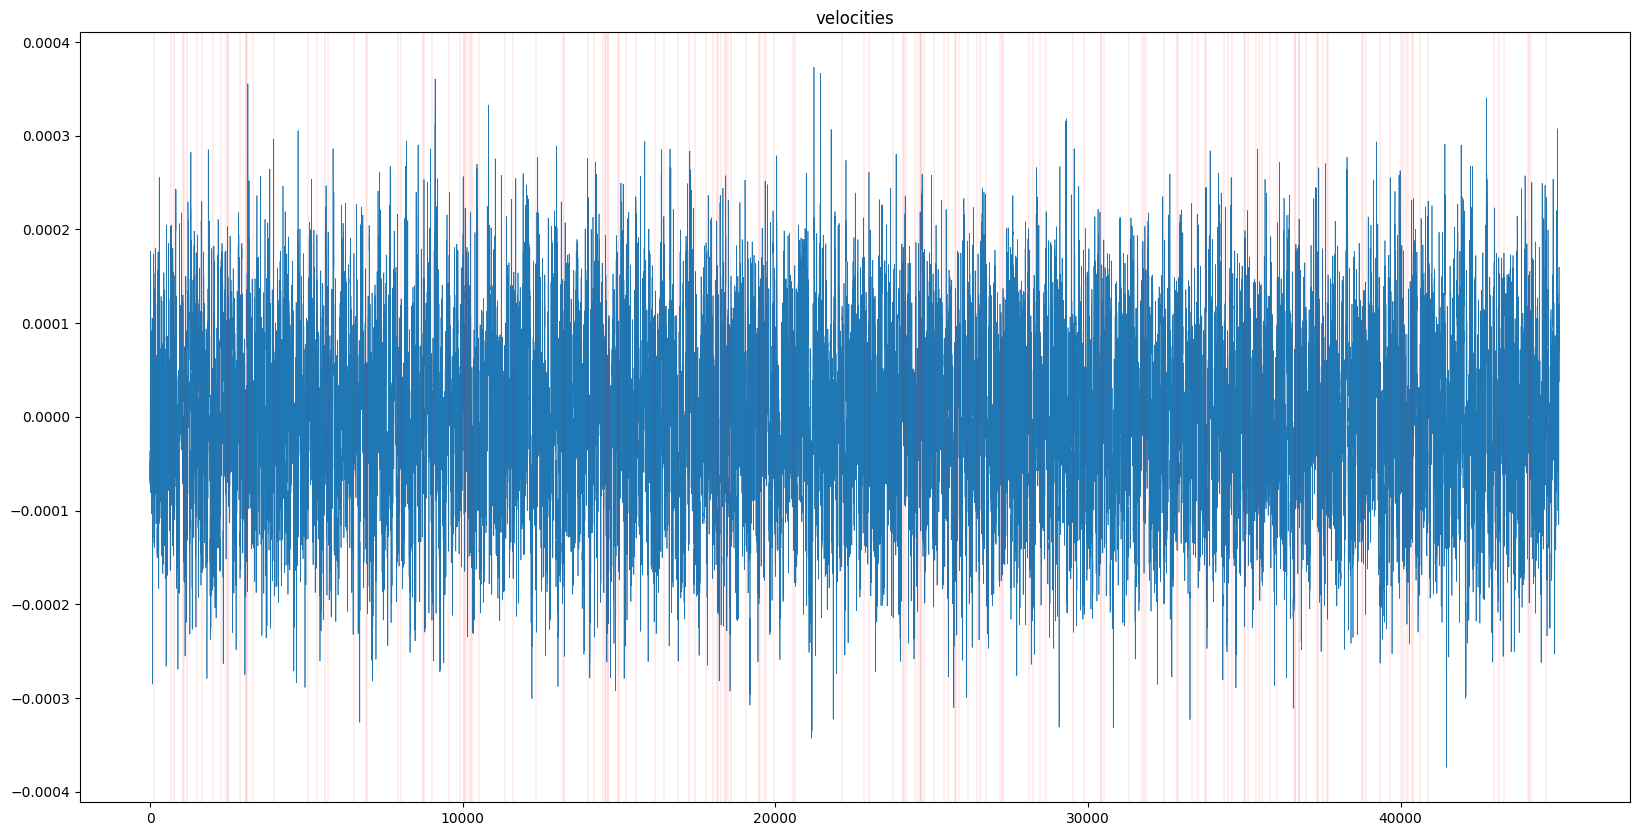

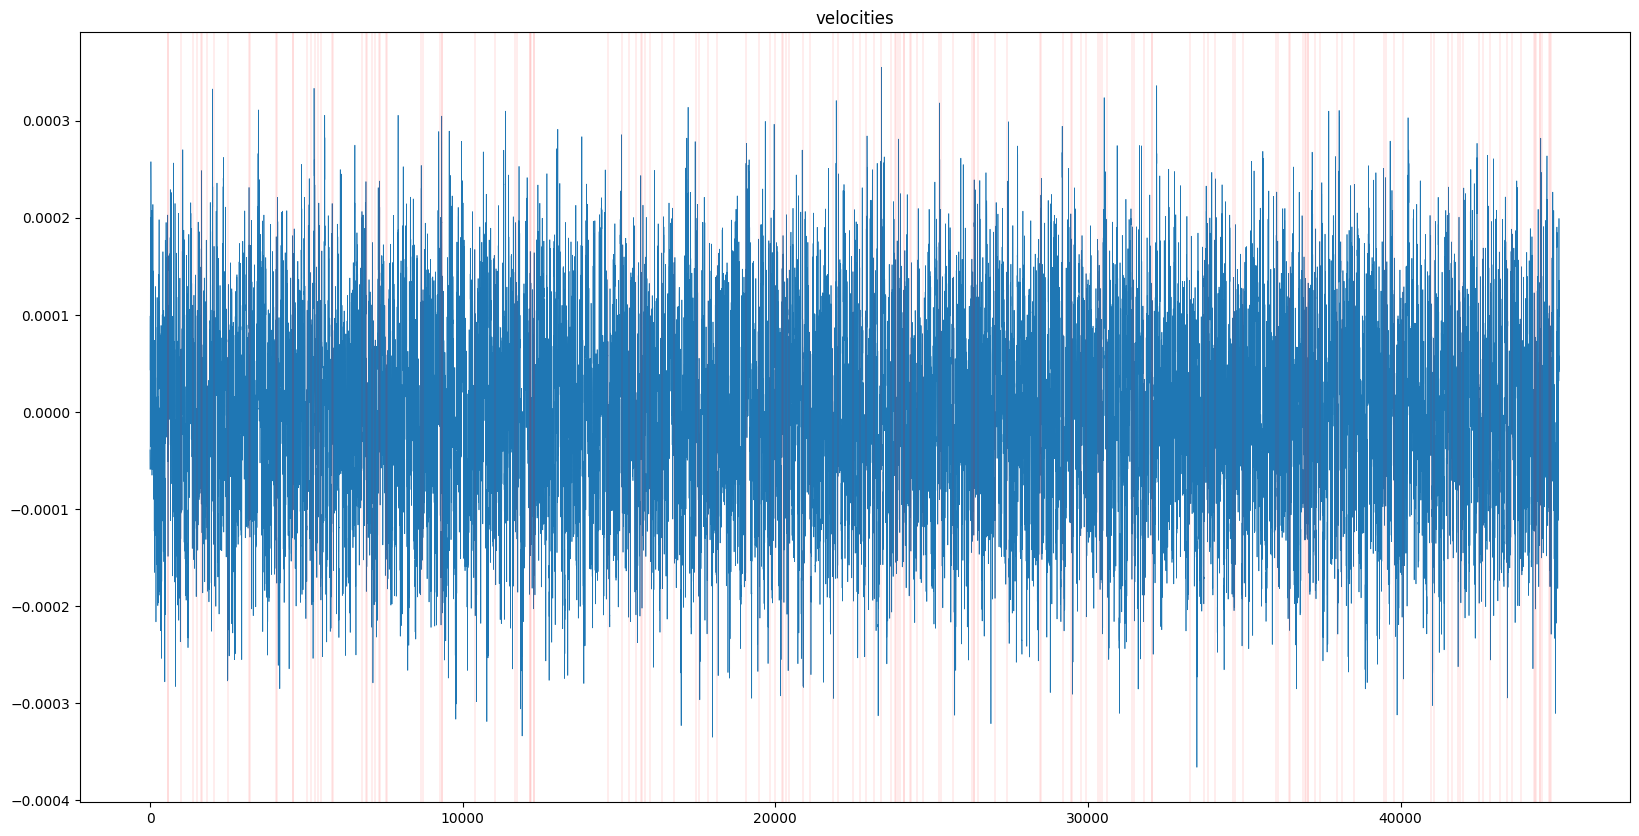

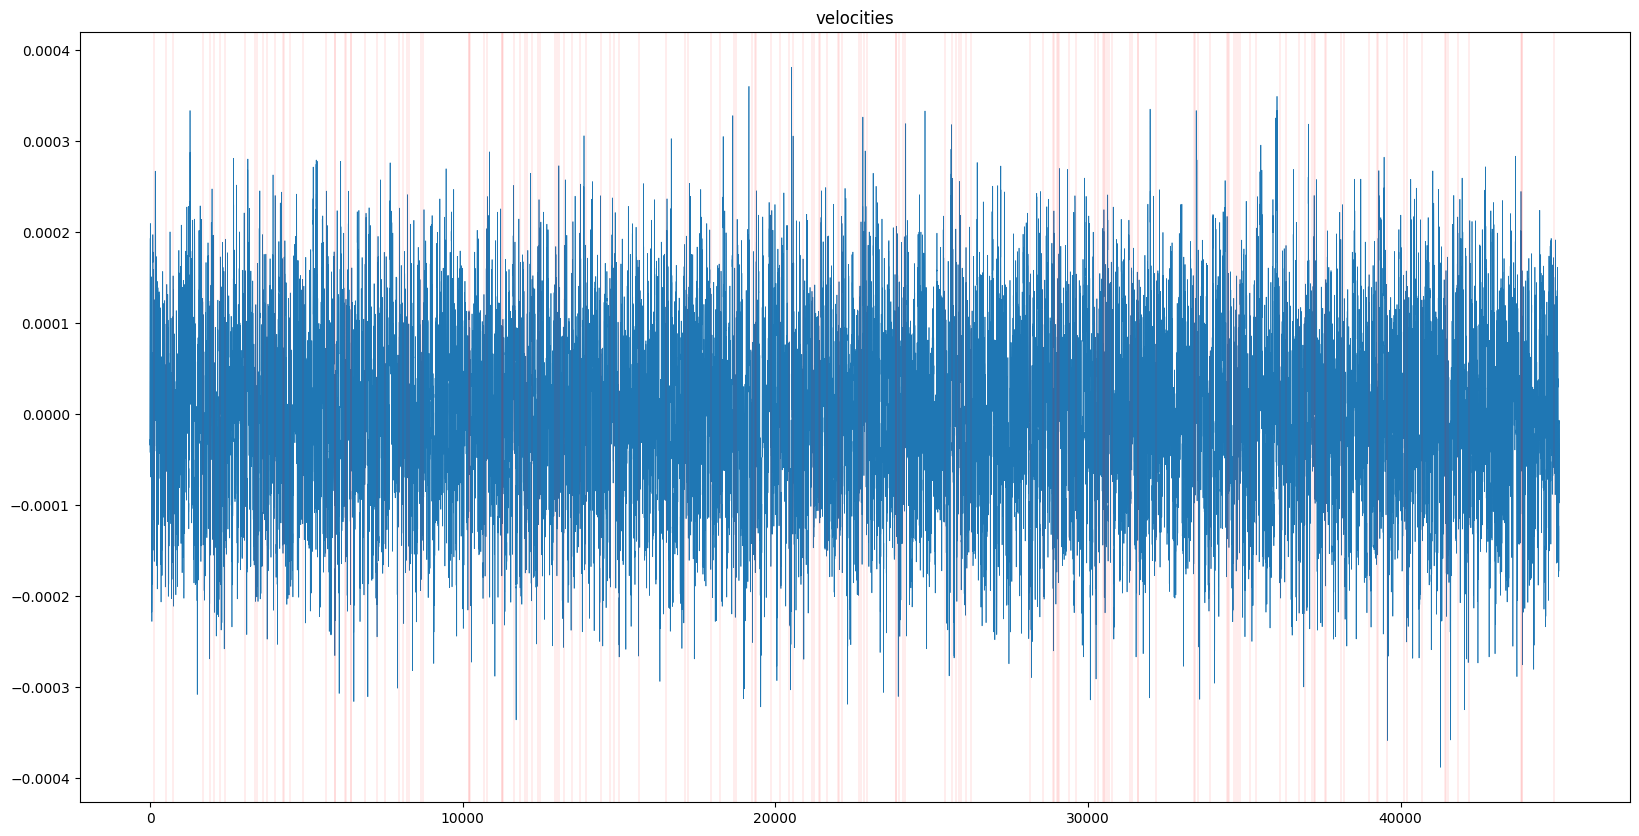

In [3]:
# Find spots where velocity is zero
import matplotlib.pyplot as plt

index_mult = 1#(timestep * sample_rate) * tao_c
x_c = 1

zero_idxs = []

for i in range(len(traces)):
    plt.figure(figsize=(20,10))
    # plt.plot([t * index_mult for t in range(len(positions[i]))], positions[i] * x_c, linewidth=0.5)
    plt.plot([t * index_mult for t in range(len(V_traces[i]))], V_traces[i], linewidth=0.5)

    tolerance = (.005*np.std(V_traces[i]))
    x_tolerance = (3*np.std(traces[i]))
    close_to_zero_indices = np.where(abs(V_traces[i]) < tolerance)[0]
    close_to_zero_x_indices = np.where(abs(traces[i]) < x_tolerance)[0]
    
    both_zero = np.intersect1d(close_to_zero_indices, close_to_zero_x_indices)
    print("zero idx: " + str(close_to_zero_indices))
    plt.title("velocities")
    # Draw vertical lines where values are close to zero
    for index in close_to_zero_indices:
        plt.axvline(x=index*index_mult, color='red', linestyle='-', linewidth=0.1)

    zero_idxs.append(close_to_zero_indices)

In [4]:
def compute_msd(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd = [(time_trace[0]-time_trace[i])**2 for i in range(n)]
    return msd, lag_times

v at rand idx is -0.00010315894778527397
v at rand idx is 3.643081246949939e-05
v at rand idx is 2.6392015362313436e-05
v at rand idx is -0.00010304863155431643
v at rand idx is -5.357075719406697e-05
v at rand idx is -5.826285475522597e-05
v at rand idx is 8.019979908049521e-05
v at rand idx is 5.012666921518101e-05
v at rand idx is 9.407892286049075e-05
v at rand idx is -7.394527753070356e-05
v at rand idx is -0.00013138437581503872
v at rand idx is 0.0001454460987057225
v at rand idx is 9.647165491856021e-05
v at rand idx is 0.0001314108859736417
v at rand idx is -9.411277857306111e-05
v at rand idx is -0.0001740983183293422
v at rand idx is 0.00012554407662935608
v at rand idx is 7.345518112020909e-06
v at rand idx is -6.90144400627597e-05
v at rand idx is -5.6087382248447223e-05
v at rand idx is -6.298025793781309e-05
v at rand idx is -8.518581566883547e-05
v at rand idx is 8.534141802803274e-05
v at rand idx is 3.319731006631853e-05
v at rand idx is -0.0001144071430587593
v at ra

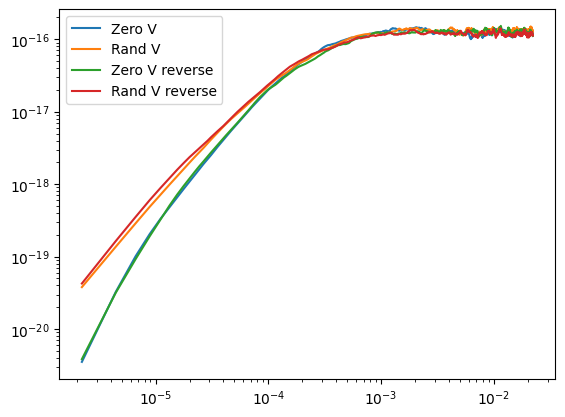

In [5]:
msd_len = 10000
lag_times = 0

import random

msds_zint = []
for i in range(len(traces)):
    for idx in zero_idxs[i]:
        if idx+msd_len < len(traces[i]):
            super_trace = traces[i][idx:idx+msd_len]
            msd, lag_times = compute_msd(super_trace, 1/fs)
            msds_zint.append(msd)

msds_rint = []
for i in range(len(traces)):
    for j in range(len(zero_idxs[i])):
        idx = random.randint(0,len(traces[i])-msd_len)
        print("v at rand idx is " + str(V_traces[i][idx]))
        reg_trace = traces[i][idx:idx+msd_len]
        msd2, lag_times = compute_msd(reg_trace, 1/fs)
        msds_rint.append(msd2)

# REVERSE
msds_zint_r = []
for i in range(len(traces)):
    for idx in zero_idxs[i]:
        if idx-msd_len > 0:
            super_trace_r = traces[i][idx-msd_len+1:idx+1]
            msd, lag_times = compute_msd(super_trace_r[::-1], 1/fs)
            msds_zint_r.append(msd)

msds_rint_r = []
for i in range(len(traces)):
    for j in range(len(zero_idxs[i])):
        idx = random.randint(msd_len,len(traces[i]))
        reg_trace = traces[i][idx-msd_len+1:idx+1]
        msd2, lag_times = compute_msd(reg_trace[::-1], 1/fs)
        msds_rint_r.append(msd2)
        
msds_zinta = np.mean(msds_zint, axis=0)
msds_rinta = np.mean(msds_rint, axis=0)
msds_zinta_r = np.mean(msds_zint_r, axis=0)
msds_rinta_r = np.mean(msds_rint_r, axis=0)

plt.plot(lag_times[1:], msds_zinta[1:], label="Zero V")
plt.plot(lag_times[1:], msds_rinta[1:], label="Rand V")
plt.plot(lag_times[1:], msds_zinta_r[1:], label="Zero V reverse")
plt.plot(lag_times[1:], msds_rinta_r[1:], label="Rand V reverse")
# plt.plot(lag_times[1:], 1e-3*lag_times[1:]**3, label="3")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
        

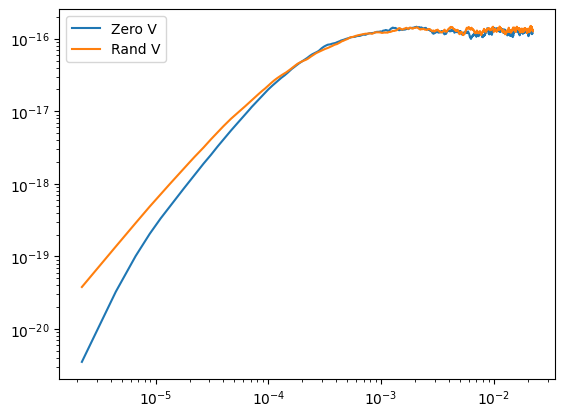

In [6]:

plt.plot(lag_times[1:], msds_zinta[1:], label="Zero V")
plt.plot(lag_times[1:], msds_rinta[1:], label="Rand V")
# plt.plot(lag_times[1:], 1e-3*lag_times[1:]**3, label="3")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
